# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import collections
import librosa
import torchaudio
import torch
import librosa.display
from keras_preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Data Preparation

### Load data

In [2]:
df_0=pd.read_csv('data sets/Dataset Sound Detection label 0.csv')
df_1=pd.read_csv('data sets/Dataset Sound Detection label 1.csv')

### Preprocess data

In [3]:
df_1=df_1.drop(columns=['Unnamed: 0'])
df_0=df_0.drop(columns=['Unnamed: 0'])

In [4]:
X_0=df_0.copy()
X_0=X_0.drop(columns=['label'])
y_0=df_0['label']
X_1=df_1.copy()
X_1=X_1.drop(columns=['label'])
y_1=df_1['label']

In [5]:
X=np.vstack((np.array(X_1),np.array(X_0))) #combine data

In [6]:
'''This function is used to add random Gaussian noise to audio data
'''
def add_noise(X):
    for i in range(len(X)):
        noise=np.random.normal(0, 0.03, X.shape[1])
        X[i]+=noise
    return(X)

In [7]:
y=np.hstack((np.array(y_1),np.array(y_0)))

In [8]:
X=add_noise(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [10]:
X_train.shape,X_test.shape

((3750, 22050), (1250, 22050))

In [11]:
print(collections.Counter(y_train))
print(collections.Counter(y_test))

Counter({0: 1876, 1: 1874})
Counter({1: 626, 0: 624})


### Create spectrogram images

In [12]:
'''This function is used to save spectrogram as images
'''
def create_spectrogram(name,array):
    plt.interactive(False)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = Spectrogram_gen(array) #generate the spectrogram
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max)) #display spectrogram as a image
    filename  = name + '.jpg'
    plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0) #save spectrogram as a image
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del name,fig,ax,S

In [13]:
'''This function is used to generate spectrogrames
'''
def Spectrogram_gen(array):
    waveform = torch.tensor(array, dtype = torch.float)
    waveform = torch.reshape(waveform, (-1,waveform.shape[0]))
    Spectrogram = torchaudio.transforms.MelSpectrogram()(waveform)[0]
    return (Spectrogram)

In [14]:
#save train spectrogram images in train directory
for i in range(len(X_train)):
    create_spectrogram('train/'+str(i),X_train[i])

C:\Users\chanakaj\Anaconda3\lib\site-packages\torchaudio\functional\functional.py:594: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [15]:
#save test spectrogram images in test directory
for i in range(len(X_test)):
    create_spectrogram('test/'+str(i),X_test[i])

### Load train and test images

In [16]:
train_images=[]
for i in range(len(y_train)):
        train_images.append(cv2.resize(cv2.imread('train/'+str(i)+'.jpg'),(64,64)))
train_images=np.array(train_images)
train_images = train_images.astype('float32') / 255
train_labels = to_categorical(np.array(y_train))

test_images=[]
for i in range(len(y_test)):
        test_images.append(cv2.resize(cv2.imread('test/'+str(i)+'.jpg'),(64,64)))
test_images=np.array(test_images)
test_images = test_images.astype('float32') / 255
test_labels = to_categorical(np.array(y_test))

In [17]:
#devide train test into train and validation sets
train_images,val_images, train_labels,val_labels = train_test_split(train_images, train_labels, test_size=0.25, random_state=42)

# Modeling

In [27]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(64,64,3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(optimizers.RMSprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 62, 62, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 31, 31, 64)       

C:\Users\chanakaj\AppData\Roaming\Python\Python38\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [28]:
history=model.fit(train_images, train_labels, epochs=150, batch_size=64,validation_data=(val_images, val_labels))

Epoch 1/150
44/44 [==============================] - 74s 2s/step - loss: 0.7041 - accuracy: 0.5025 - val_loss: 0.6927 - val_accuracy: 0.5171
Epoch 2/150
44/44 [==============================] - 44s 1s/step - loss: 0.6991 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.4829
Epoch 3/150
44/44 [==============================] - 57s 1s/step - loss: 0.6939 - accuracy: 0.5181 - val_loss: 0.6898 - val_accuracy: 0.6311
Epoch 4/150
44/44 [==============================] - 153s 4s/step - loss: 0.6922 - accuracy: 0.5487 - val_loss: 0.7034 - val_accuracy: 0.4872
Epoch 5/150
44/44 [==============================] - 55s 1s/step - loss: 0.6921 - accuracy: 0.5573 - val_loss: 0.6731 - val_accuracy: 0.6034
Epoch 6/150
44/44 [==============================] - 48s 1s/step - loss: 0.6844 - accuracy: 0.5679 - val_loss: 0.6891 - val_accuracy: 0.4936
Epoch 7/150
44/44 [==============================] - 53s 1s/step - loss: 0.6813 - accuracy: 0.5811 - val_loss: 0.6653 - val_accuracy: 0.6055
Epoch 8/150


44/44 [==============================] - 152s 4s/step - loss: 0.3391 - accuracy: 0.8457 - val_loss: 0.4064 - val_accuracy: 0.7846
Epoch 116/150
44/44 [==============================] - 102s 2s/step - loss: 0.3576 - accuracy: 0.8368 - val_loss: 0.3855 - val_accuracy: 0.8198
Epoch 117/150
44/44 [==============================] - 89s 2s/step - loss: 0.3372 - accuracy: 0.8510 - val_loss: 0.3526 - val_accuracy: 0.8443
Epoch 118/150
44/44 [==============================] - 131s 3s/step - loss: 0.3371 - accuracy: 0.8410 - val_loss: 0.3912 - val_accuracy: 0.8262
Epoch 119/150
44/44 [==============================] - 80s 2s/step - loss: 0.3438 - accuracy: 0.8432 - val_loss: 0.3429 - val_accuracy: 0.8497
Epoch 120/150
44/44 [==============================] - 54s 1s/step - loss: 0.3243 - accuracy: 0.8489 - val_loss: 0.3477 - val_accuracy: 0.8401
Epoch 121/150
44/44 [==============================] - 182s 4s/step - loss: 0.3185 - accuracy: 0.8460 - val_loss: 0.3446 - val_accuracy: 0.8337
Epoch 122

# Evaluate

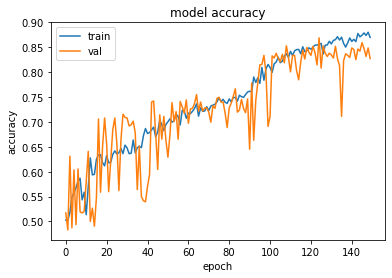

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

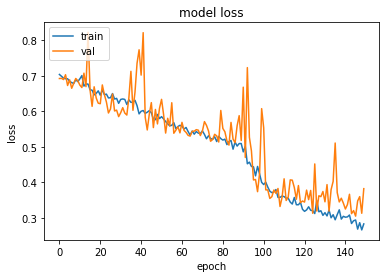

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### predict for test data

In [31]:
pred=model.predict(test_images)
predicted_class_indices=np.argmax(pred,axis=1)

In [32]:
acc=accuracy_score(predicted_class_indices,y_test)
print('accuracy is :-',acc)

accuracy is :- 0.836


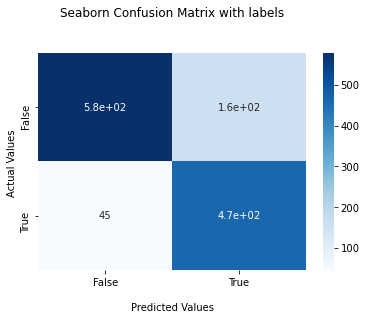

In [33]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(predicted_class_indices,y_test)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Save model

In [34]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
